Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 415s 405ms/step - accuracy: 0.6101 - loss: 0.9314 - val_accuracy: 0.8719 - val_loss: 0.3446
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 430s 394ms/step - accuracy: 0.9042 - loss: 0.2739 - val_accuracy: 0.8981 - val_loss: 0.2931
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 462s 414ms/step - accuracy: 0.9285 - loss: 0.2023 - val_accuracy: 0.8953 - val_loss: 0.3091
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8942 - loss: 0.3030

Test accuracy: 0.8953
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step

Classification Report:
              precision    recall  f1-score   support

      Cretan       0.89      0.87      0.88      2016
       Greek       0.79      0.91      0.85      1993
        cypr       0.88      0.85      0.87      2043
     nothern       0.98      0.95      0.97      1950
      pontic       0.95      0.90      0.92      1998

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     1000

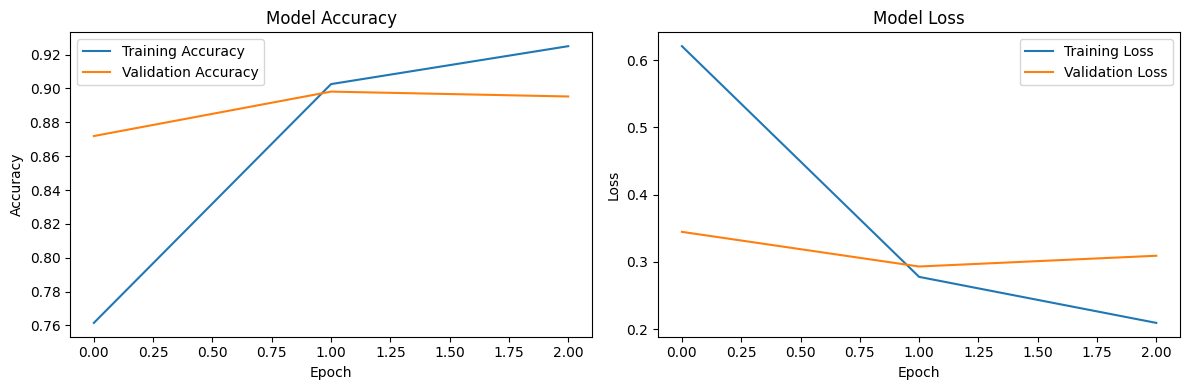

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from google.colab import drive

drive.mount('/content/drive/')
# Load and preprocess data
df = pd.read_csv('/content/drive/My Drive/10k.csv', sep=';', header=None, names=["article", "lang"])
filtered_df = df[df['lang'] != 'lang']
f_df = filtered_df[filtered_df['lang'] != 'lang']

texts = f_df['article'].values
labels = f_df['lang'].values

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
one_hot_labels = to_categorical(encoded_labels)

# Tokenize text
max_words = 10000  # Maximum number of words to keep
max_len = 200      # Maximum length of each text

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_labels, test_size=0.2, random_state=42)

# Create BiLSTM model
model = Sequential([
    # Embedding layer
    Embedding(max_words, 100, input_length=max_len),

    # First BiLSTM layer with dropout
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    # Second BiLSTM layer with dropout
    Bidirectional(LSTM(32)),
    Dropout(0.3),

    # Dense layers with dropout
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()